In [1]:
from imports import *
import AudioTransforms
from DeReverbDataset import *
from utils import *
matplotlib.rcParams['figure.figsize'] = [10, 8]

In [4]:
speech_sr = 16000
data_path = Path("data")

## Create Transforms
`rev_tfms` is the transforms that will only be applied to the reverberant audio (input)  
`clean_tfms` is the transforms that will also be applied to the clean audio signal (target)

Note: if sample rate of files does not match sample rate passed, transforms will resample all audio files they need. This can take a *WHILE* if the conflicting sample rates are not integer multiples.

In [5]:
rev_tfms = transforms.Compose([AudioTransforms.Noise(data_path/'noise', speech_sr, -6, 2),
                               AudioTransforms.Reverb(data_path/'impulse-responses', speech_sr)])
clean_tfms = transforms.Compose([AudioTransforms.RandomCrop(5 * speech_sr)])

## Create a Dataset

In [4]:
dataset = DeReverbDataset(data_path, rev_tfms=rev_tfms, clean_tfms=clean_tfms)

## Create a Dataloader

In [5]:
dl = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=6)

## Check out some data

In [6]:
batch_ex = next(iter(dl))

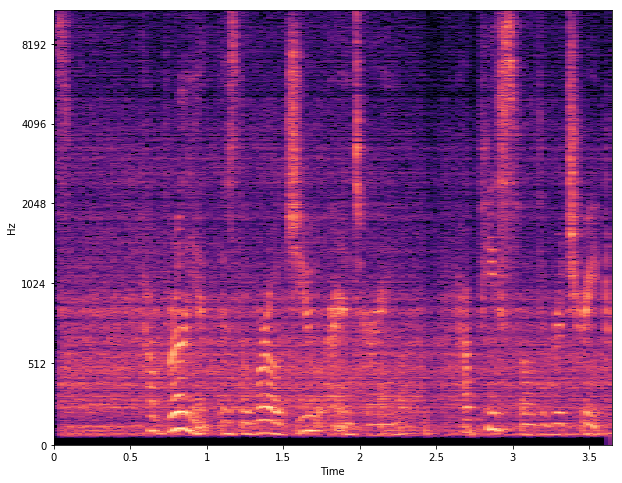

In [10]:
plot_spec(batch_ex['reverbed'][0])
Audio(batch_ex['reverbed'][0], rate=speech_sr)

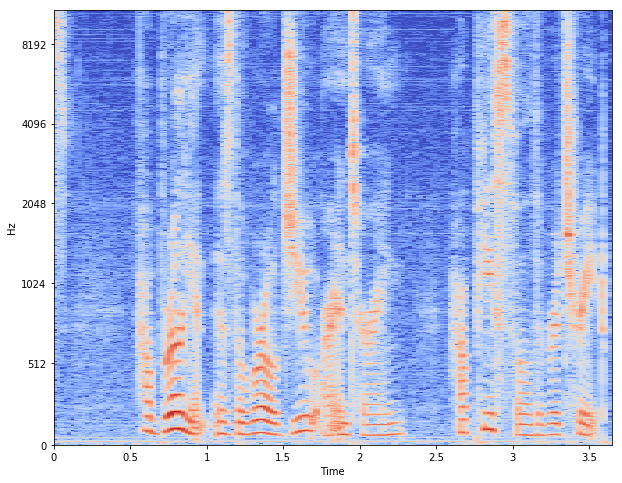

In [11]:
plot_spec(batch_ex['clean'][0])
Audio(batch_ex['reverbed'][0], rate=speech_sr)

fin.